<a href="https://colab.research.google.com/github/lisijia6/Exploring-Optimization-in-Deep-Learning-with-Various-Algorithms/blob/main/Notebooks/Model_Architecture_sgd_lrd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* training: 70%; validation: 15%; testing: 15%
* Various data augmentation techniques have been applied to increase the number of training samples to reduce overfitting and improve generalization. The data augmentation techniques used are brightness, rotation, width shift, height shift, shearing, zooming, vertical flip, and horizontal flip. Also, featurewise centering, featurewise standard deviation normalization and fill mode. Before the images were supplied to other stages, they were resized to a 180 x 180.

-
A pre-trained network is taken, and its classifier base is removed.

-
The convolutional base of the pre-trained model is frozen.

-
A new classifier is added and trained on top of the convolutional base of the pre-trained network.

-
Unfreeze some layers of the convolutional base of the pre-trained network.

-
Finally, both these unfrozen layers and the new classifier are jointly trained.

https://www.sciencedirect.com/science/article/pii/S1568494620306803?casa_token=4ieLFywpVeUAAAAA:PeXRbdBj46bl9y-0SZOOE30EekImtXEMDC592HLOaOSNjKVMLBh5a9-MKeVbrATUJE8RwrSl#b26

# Import Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/MIE424/Exploring-Optimization-in-Deep-Learning-with-Various-Algorithms/Notebooks"

/content/drive/.shortcut-targets-by-id/1-0yfWCW69kavV8g4Zyl8jxmL2psN6QQU/MIE424/Exploring-Optimization-in-Deep-Learning-with-Various-Algorithms/Notebooks


In [ ]:
!pip install import-ipynb
import import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=16334367dab37fa2026cd778adc80e97bd569aafe1e1cd55f2ac90aa1876fa9c
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time 
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

from torch.optim import Optimizer
from torch.distributions import Bernoulli, Normal
import torchvision.models

from copy import deepcopy

In [ ]:
import Optimizers

importing Jupyter notebook from Optimizers.ipynb


In [ ]:
# import misc

# Get Data Loader

In [ ]:
def get_data_loader(target_classes, batch_size, num_workers):
    np.random.seed(1000) # fixed numpy seed for reproducible shuffling
    classes = ['Covid Negative', 'Covid Positive'] # classes are folders in each directory with these names

    tensor_data_path = "/content/drive/My Drive/MIE424/Exploring-Optimization-in-Deep-Learning-with-Various-Algorithms/Data/Tensor/"
    data = torchvision.datasets.DatasetFolder(tensor_data_path, loader=torch.load, extensions=('.pt')) # stored in tensors
    
    relevant_indices = list(range(len(data)))
    np.random.shuffle(relevant_indices)
    # relevant_indices = relevant_indices[0:1000]

    # Splitting data: 70% train, 15% validation, 15% test
    train_val_split = int(len(relevant_indices) * 0.7)
    val_test_split = int(len(relevant_indices) * 0.85)
    relevant_train_indices, relevant_val_indices, relevant_test_indices = relevant_indices[:train_val_split], relevant_indices[train_val_split:val_test_split], relevant_indices[val_test_split:]

    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, num_workers=num_workers, sampler=train_sampler, drop_last=True)
    
    val_sampler = SubsetRandomSampler(relevant_val_indices) 
    val_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, num_workers=num_workers, sampler=val_sampler, drop_last=True)

    test_sampler = SubsetRandomSampler(relevant_test_indices) 
    test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, num_workers=num_workers, sampler=test_sampler, drop_last=True)

    return train_loader, val_loader, test_loader, classes

# Training Code

In [ ]:
# Generate a name for each training hyperparameter settings, which is a string consisting of all hyperparameters of a model
def get_model_name(name, batch_size, other_param_names, epoch):
    path = "model_{0}_bs{1}_{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   other_param_names,
                                                   epoch)
    return path  #get a string consisting of all hyperparameters of a model

In [ ]:
def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

In [ ]:
def evaluate(net, loader, criterion):
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if use_cuda and torch.cuda.is_available():
          inputs = inputs.cuda()
          labels = labels.cuda()
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)

        loss = criterion(outputs+1e-10, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels.tolist())

    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

In [ ]:
def train(model, train_data, val_data, optimizer, other_param_names, batch_size=64, num_epochs=1):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    criterion = nn.BCEWithLogitsLoss()
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss = np.zeros(num_epochs)
    train_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    
    
    # training
    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        
        for i, data in enumerate(train_loader):
            inputs, labels = data # Get the inputs
            if use_cuda and torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()

            out = model(inputs)             # forward pass
            loss = criterion(out+1e-10, labels.float()) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Save the current training information
            total_train_loss += loss.item()             # compute train loss
        
        # Calculate error and loss for training and validation set for this epoch
        train_err[epoch], train_loss[epoch] = evaluate(model, train_loader, criterion)   # compute average train error and loss
        val_err[epoch], val_loss[epoch] = evaluate(model, val_loader, criterion)   # compute validation error and loss
        print(("Epoch {}: Train err: {}, Train loss: {} | "+
               "Val err: {}, Val loss: {} | Time: {:.2f}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch], 
                   time.time() - start_time))
        
        # Save the current model (checkpoint) to a file, every 10 epoch - always save the last epoch
        if (epoch % 10 == 0) or (epoch == num_epochs-1):
          model_path = get_model_name(model.name, batch_size, other_param_names, epoch)
          torch.save(model.state_dict(), model_path)
        
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    
    # Write the train/test loss/accuracy into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    model_path = get_model_name(model.name, batch_size, other_param_names, num_epochs)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    print("Final Training Error: {}".format(train_err[-1]))

In [ ]:
def plot_training_curve(path, epochs=1):
    # Load the training and validation accuracy and loss
    train_acc = np.loadtxt("{}_train_err.csv".format(path))
    val_acc = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    
    plt.title("Train vs Validation Classification Error")
    plt.plot(range(1,epochs+1), train_acc, label="Train")
    plt.plot(range(1,epochs+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Classification Error")
    plt.legend(loc='best')
    plt.show()
    
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,epochs+1), train_loss, label="Train")
    plt.plot(range(1,epochs+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    
    plt.show()

# misc for Optimizers

https://github.com/nicklashansen/neural-net-optimization/blob/master/misc.py

In [ ]:
optim_dict = {
		'sgd': {
			'label': 'SGD',
			'lr': 1e-3
		},
		'sgd_momentum': {
			'label': 'SGD w/ momentum',
			'lr': 1e-3,
			'mu': 0.99
		},
		'sgd_nesterov': {
			'label': 'SGD w/ Nesterov momentum',
			'lr': 1e-3,
			'mu': 0.99,
			'nesterov': True
		},
		'sgd_weight_decay': {
			'label': 'SGDW',
			'lr': 1e-3,
			'mu': 0.99,
			'weight_decay': 1e-6
		},
		'sgd_lrd': {
			'label': 'SGD w/ momentum + LRD',
			'lr': 1e-3,
			'mu': 0.99,
			'lrd': 0.5
		},
		'adam': {
			'label': 'Adam',
			'lr': 1e-3
		},
		'adamW':{
			'label': 'AdamW',
			'lr': 1e-3,
			'weight_decay': 1e-4
		},
		'adam_l2':{
			'label': 'AdamL2',
			'lr': 1e-3,
			'l2_reg': 1e-4
		},
		'adam_lrd': {
			'label': 'Adam w/ LRD',
			'lr': 1e-3,
			'lrd': 0.5
		},
		'Radam': {
			'label': 'RAdam',
			'lr': 1e-3,
			'rectified': True
		},
		'RadamW': {
			'label': 'RAdamW',
			'lr': 1e-3,
			'rectified': True,
			'weight_decay': 1e-4
		},
		'Radam_lrd': {
			'label': 'RAdam w/ LRD',
			'lr': 1e-3,
			'rectified': True,
			'lrd': 0.5
		},
		'nadam': {
			'label': 'Nadam',
			'lr': 1e-3,
			'nesterov': True
		},
		'rmsprop': {
			'label': 'RMSprop',
			'lr': 1e-3,
			'beta2': 0.9,
		},
		'lookahead_sgd': {
			'label': 'Lookahead (SGD)',
			'lr': 1e-3,
			'mu': 0.99
		},
		'lookahead_adam': {
			'label': 'Lookahead (Adam)',
			'lr': 1e-3
		},
		'gradnoise_adam': {
			'label': 'Gradient Noise (Adam)',
			'lr': 1e-3
		},
		'graddropout_adam': {
			'label': 'Gradient Dropout (Adam)',
			'lr': 1e-3
		}
	}

In [ ]:
def split_optim_dict(d:dict) -> tuple:
	"""
	Splits an optimization dict into label and dict.
	"""
	temp_d = deepcopy(d)
	label = temp_d['label']
	del temp_d['label']

	return label, temp_d

In [ ]:
def task_to_optimizer(task:str) -> torch.optim.Optimizer:
	"""
	Takes a task as string and returns its respective optimizer class.
	"""
	optimizer = None

	if 'sgd' in task.lower():
		optimizer = getattr(Optimizers, 'SGD')
	if 'adam' in task.lower():
		optimizer = getattr(Optimizers, 'Adam')
	if 'rmsprop' in task.lower():
		optimizer = getattr(Optimizers, 'RMSProp')
	
	if optimizer is None:
		raise ValueError(f'Optimizer for task \'{task}\' was not recognized!')

	return optimizer

In [ ]:
def wrap_optimizer(task:str, optimizer):
	"""
	Wraps an instantiated optimizer according to its task specified as a string.
	"""
	if 'gradnoise' in task.lower():
		optimizer = Optimizers.GradientNoise(optimizer, eta=0.3, gamma=0.55)

	if 'graddropout' in task.lower():
		optimizer = Optimizers.GradientDropout(optimizer, grad_retain=0.9)

	if 'lookahead' in task.lower():
		optimizer = Optimizers.Lookahead(optimizer, k=5, alpha=0.5)

	return optimizer

# Model Training

In [ ]:
# Visualize some sample data
# dataiter = iter(train_loader)
# images,labels = dataiter.next()
# images = images.numpy()
# classes = ['Covid Negative', 'Covid Positive']
# # plot the images in the batch, along with corresponding labels
# fig = plt.figure(figsize=(25,4))
# for idx in np.arange(20):
#   ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
#   plt.imshow(np.transpose(images[idx], (1, 2, 0)))
#   ax.set_title(classes[labels[idx]])

In [ ]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet169', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet201', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet161', pretrained=True)
#model.eval()

# num_ftrs = model.classifier.in_features
# model.classifier = nn.Linear(num_ftrs, 340)
# model.features.conv0.apply(squeeze_weights)
# model.classifier2 = nn.Linear(340, 1)

In [ ]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
# model.classifier.in_features

In [ ]:
opt_tasks = [
		'sgd',
		'sgd_momentum',
		'sgd_nesterov',
		'sgd_weight_decay',
		'sgd_lrd',
		'rmsprop',
		'adam',
		'adam_l2',
		'adamW',
		'adam_lrd',
		'Radam',
		'RadamW',
		'Radam_lrd',
		'nadam',
		'lookahead_sgd',
		'lookahead_adam',
		'gradnoise_adam',
		'graddropout_adam'
	]

https://www.kaggle.com/code/leighplt/densenet121-pytorch/notebook

In [ ]:
class TransferDenseNet121Classifier(nn.Module):
    def __init__(self):
        super(TransferDenseNet121Classifier, self).__init__()
        self.name = 'densenet121Classifier_sgd_lrd'
        preloaded = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
        self.features = preloaded.features

        self.features.conv0 = nn.Conv2d(3, 64, 7, 2, 3)
        # self.num_ftrs = self.model.classifier.in_features
        self.fc1 = nn.Linear(1024, 340)
        self.fc2 = nn.Linear(340, 1)
        del preloaded
    
    def forward(self, x):
        features = self.features(x)
        x = F.relu(features, inplace=True)
        # x = x.view(-1, self.num_ftrs)
        # x = F.relu(features, inplace=True)
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(features.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

* SGD (Amanda), SGD w/ momentum (Coco), SGD w/ Nesterov momentum (Amanda), SGD w/ LRD (Coco)
* Adam (Nancy), Adam w/ L2 (Kelly), Adam w/ LRD (Nancy), AdamW (Kelly)
* KO optimizer

hyperparameter combinations:
1. bs=32, lr=0.01, num_epochs=30
2. bs=32, lr=0.001, num_epochs=30
3. bs=64, lr=0.01, num_epochs=30
4. bs=64, lr=0.001, num_epochs=30

In [ ]:
# _, kwargs = split_optim_dict(optim_dict['sgd_momentum'])

In [ ]:
# kwargs

In [ ]:
# kwargs['lr'] = 0.01
# kwargs

Batch Size: 32 
Lr = 0.01, 0.001 
Mu = 0.99, 0.9, 0.8


In [ ]:
batch_size = 32
train_loader, val_loader, test_loader, classes = get_data_loader(['Covid Negative', 'Covid Positive'], batch_size, 1)
# get number of images in training, validation, and testing sets
print('Num in training set:',len(train_loader)*batch_size)
print('Num in validation set:',len(val_loader)*batch_size)
print('Num in testing set:',len(test_loader)*batch_size)

Num in training set: 1440
Num in validation set: 288
Num in testing set: 288


Started New Setting: 
   Hyper-Parameters:  LR =  0.001  MU =  0.9  LRD =  0.4


Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

{'lr': 0.001, 'mu': 0.9, 'lrd': 0.4}
Training with CUDA!
Epoch 1: Train err: 0.2625, Train loss: 0.6313880191908943 | Val err: 0.3055555555555556, Val loss: 0.6375367641448975 | Time: 356.47
Epoch 2: Train err: 0.21388888888888888, Train loss: 0.5499892698393928 | Val err: 0.2465277777777778, Val loss: 0.5671848323610094 | Time: 404.29
Epoch 3: Train err: 0.20208333333333334, Train loss: 0.48498070306248137 | Val err: 0.20833333333333334, Val loss: 0.5000882512993283 | Time: 448.34
Epoch 4: Train err: 0.18958333333333333, Train loss: 0.428165242407057 | Val err: 0.2222222222222222, Val loss: 0.47865702708562213 | Time: 492.55
Epoch 5: Train err: 0.15763888888888888, Train loss: 0.3748748130268521 | Val err: 0.21180555555555555, Val loss: 0.4280433886580997 | Time: 536.67
Epoch 6: Train err: 0.11736111111111111, Train loss: 0.3149793532159593 | Val err: 0.20833333333333334, Val loss: 0.43040523595280117 | Time: 580.74
Epoch 7: Train err: 0.10277777777777777, Train loss: 0.27776641647020

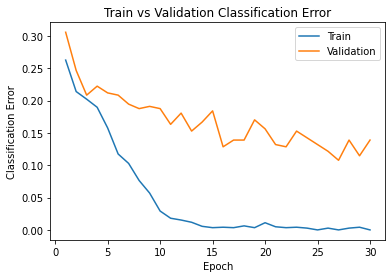

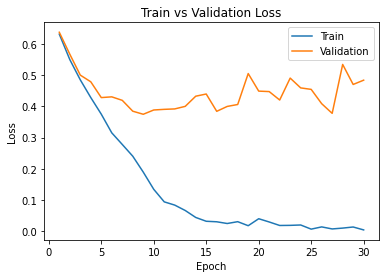

Finished training for the current setting: 
   Hyper-Parameters:  LR =  0.001  MU =  0.9  LRD =  0.4
Started New Setting: 
   Hyper-Parameters:  LR =  0.001  MU =  0.9  LRD =  0.5


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.001, 'mu': 0.9, 'lrd': 0.5}
Training with CUDA!
Epoch 1: Train err: 0.275, Train loss: 0.6293877972496881 | Val err: 0.3159722222222222, Val loss: 0.6394141051504347 | Time: 43.98
Epoch 2: Train err: 0.21597222222222223, Train loss: 0.5308298607667287 | Val err: 0.2465277777777778, Val loss: 0.5560541914569007 | Time: 88.23
Epoch 3: Train err: 0.20416666666666666, Train loss: 0.45449707839224074 | Val err: 0.1701388888888889, Val loss: 0.4621516201231215 | Time: 132.31
Epoch 4: Train err: 0.17152777777777778, Train loss: 0.3863700376616584 | Val err: 0.1909722222222222, Val loss: 0.42967046631707084 | Time: 176.32
Epoch 5: Train err: 0.12013888888888889, Train loss: 0.3225671042998632 | Val err: 0.19444444444444445, Val loss: 0.39502086904313827 | Time: 220.23
Epoch 6: Train err: 0.08819444444444445, Train loss: 0.2584421816799376 | Val err: 0.1875, Val loss: 0.3759285542700026 | Time: 264.21
Epoch 7: Train err: 0.04722222222222222, Train loss: 0.17950499653816224 | Val err: 0

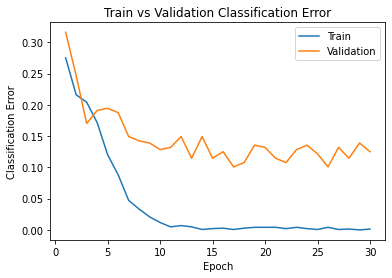

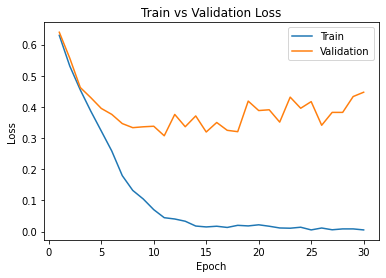

Finished training for the current setting: 
   Hyper-Parameters:  LR =  0.001  MU =  0.9  LRD =  0.5
Started New Setting: 
   Hyper-Parameters:  LR =  0.001  MU =  0.9  LRD =  0.6


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.001, 'mu': 0.9, 'lrd': 0.6}
Training with CUDA!
Epoch 1: Train err: 0.2590277777777778, Train loss: 0.6109404510921902 | Val err: 0.2708333333333333, Val loss: 0.6179360681109958 | Time: 44.00
Epoch 2: Train err: 0.21458333333333332, Train loss: 0.4958735466003418 | Val err: 0.24305555555555555, Val loss: 0.5295645594596863 | Time: 88.36
Epoch 3: Train err: 0.17847222222222223, Train loss: 0.4122138155831231 | Val err: 0.19444444444444445, Val loss: 0.43915777736239964 | Time: 132.37
Epoch 4: Train err: 0.1388888888888889, Train loss: 0.32934198247061836 | Val err: 0.17708333333333334, Val loss: 0.4010708232720693 | Time: 176.35
Epoch 5: Train err: 0.08263888888888889, Train loss: 0.27011266350746155 | Val err: 0.15625, Val loss: 0.35461023781034684 | Time: 220.28
Epoch 6: Train err: 0.05694444444444444, Train loss: 0.1851022634241316 | Val err: 0.16319444444444445, Val loss: 0.34485801723268295 | Time: 264.23
Epoch 7: Train err: 0.027083333333333334, Train loss: 0.12384267532

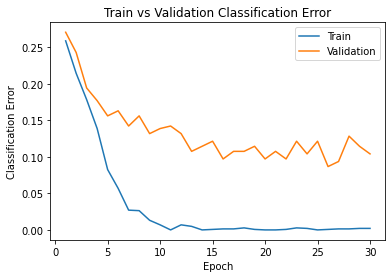

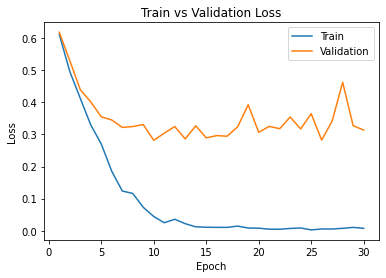

Finished training for the current setting: 
   Hyper-Parameters:  LR =  0.001  MU =  0.9  LRD =  0.6


In [ ]:
lrs = [0.001]
mus = [0.9]
lrds = [0.4, 0.5, 0.6]

for l in lrs:
  for m in mus:
    for d in lrds:
      print("=====================================================================")
      print("Started New Setting: ")
      print("   Hyper-Parameters: ", "LR = ", l, " MU = ", m, " LRD = ", d)

      # Train with default batch size and learning rate
      use_cuda = True

      model = TransferDenseNet121Classifier()
      _, kwargs = split_optim_dict(optim_dict['sgd_lrd'])
      lr, mu, lrd = l, m, d
      kwargs['lr'], kwargs['mu'], kwargs['lrd'] = lr, mu, lrd
      print(kwargs)
      optimizer = task_to_optimizer('sgd_lrd')(params=model.parameters(), **kwargs)
      optimizer = wrap_optimizer('sgd_lrd', optimizer)
      if use_cuda and torch.cuda.is_available():
        model.cuda()
        print("Training with CUDA!")
      else:
        print("CUDA not available...")
      other_param_names = 'lr{}_mu{}_lrd{}'.format(lr, mu, lrd)
      train(model, train_loader, val_loader, optimizer, other_param_names, batch_size=batch_size, num_epochs=30)


      #plot
      # Plotting is used for choosing hyperparameters
      model_path = get_model_name('densenet121Classifier_sgd_lrd', batch_size=batch_size, other_param_names = other_param_names, epoch=30)
      plot_training_curve(model_path, epochs=30)
      print("Finished training for the current setting: ")
      print("   Hyper-Parameters: ", "LR = ", l, " MU = ", m, " LRD = ", d)
      print("=====================================================================")

Started New Setting: 
   Hyper-Parameters:  LR =  0.01  MU =  0.99  LRD =  0.4


Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

{'lr': 0.01, 'mu': 0.99, 'lrd': 0.4}
Training with CUDA!
Epoch 1: Train err: 0.20972222222222223, Train loss: 0.41561792492866517 | Val err: 0.21180555555555555, Val loss: 0.45017220907741123 | Time: 603.64
Epoch 2: Train err: 0.14166666666666666, Train loss: 0.34798943599065146 | Val err: 0.2152777777777778, Val loss: 0.41841599345207214 | Time: 656.27
Epoch 3: Train err: 0.17152777777777778, Train loss: 0.36391916473706565 | Val err: 0.2048611111111111, Val loss: 0.474533607562383 | Time: 702.42
Epoch 4: Train err: 0.15416666666666667, Train loss: 0.3105786373217901 | Val err: 0.19444444444444445, Val loss: 0.4160902798175812 | Time: 748.62
Epoch 5: Train err: 0.11041666666666666, Train loss: 0.26983434359232583 | Val err: 0.18055555555555555, Val loss: 0.37624398205015397 | Time: 794.45
Epoch 6: Train err: 0.10902777777777778, Train loss: 0.2522857838206821 | Val err: 0.1597222222222222, Val loss: 0.35493294729126823 | Time: 840.24
Epoch 7: Train err: 0.10208333333333333, Train loss

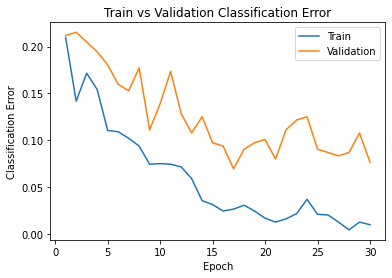

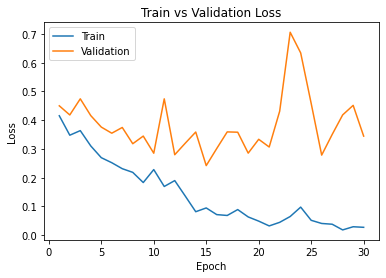

Finished training for the current setting: 
   Hyper-Parameters:  LR =  0.01  MU =  0.99  LRD =  0.4
Started New Setting: 
   Hyper-Parameters:  LR =  0.01  MU =  0.99  LRD =  0.5


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.01, 'mu': 0.99, 'lrd': 0.5}
Training with CUDA!
Epoch 1: Train err: 0.19444444444444445, Train loss: 0.4200318687491947 | Val err: 0.2222222222222222, Val loss: 0.4845447275373671 | Time: 45.87
Epoch 2: Train err: 0.15486111111111112, Train loss: 0.32089878453148735 | Val err: 0.1701388888888889, Val loss: 0.39711112446255153 | Time: 91.89
Epoch 3: Train err: 0.14722222222222223, Train loss: 0.3523364371723599 | Val err: 0.14583333333333334, Val loss: 0.3635720411936442 | Time: 137.48
Epoch 4: Train err: 0.15625, Train loss: 0.29815218879116906 | Val err: 0.21875, Val loss: 0.40941059589385986 | Time: 183.42
Epoch 5: Train err: 0.14097222222222222, Train loss: 0.35239594413174524 | Val err: 0.15625, Val loss: 0.36903219752841526 | Time: 229.25
Epoch 6: Train err: 0.12291666666666666, Train loss: 0.28651763167646194 | Val err: 0.12152777777777778, Val loss: 0.31801681220531464 | Time: 274.93
Epoch 7: Train err: 0.1125, Train loss: 0.24307593256235122 | Val err: 0.13194444444444

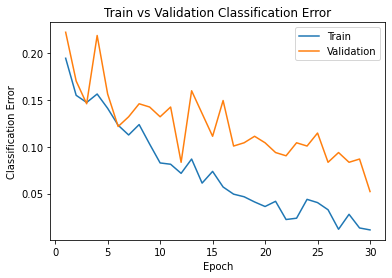

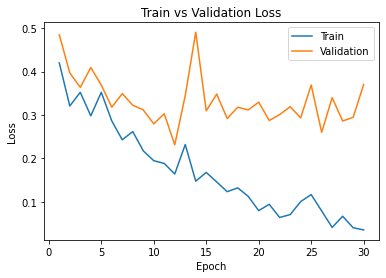

Finished training for the current setting: 
   Hyper-Parameters:  LR =  0.01  MU =  0.99  LRD =  0.5
Started New Setting: 
   Hyper-Parameters:  LR =  0.01  MU =  0.99  LRD =  0.6


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.01, 'mu': 0.99, 'lrd': 0.6}
Training with CUDA!
Epoch 1: Train err: 0.2013888888888889, Train loss: 0.4412374688519372 | Val err: 0.2326388888888889, Val loss: 0.4669635858800676 | Time: 45.68
Epoch 2: Train err: 0.17708333333333334, Train loss: 0.3670018606715732 | Val err: 0.20833333333333334, Val loss: 0.4882653057575226 | Time: 91.68
Epoch 3: Train err: 0.14583333333333334, Train loss: 0.35945221914185416 | Val err: 0.1597222222222222, Val loss: 0.41057393617100185 | Time: 137.17
Epoch 4: Train err: 0.13402777777777777, Train loss: 0.31557838751210104 | Val err: 0.14930555555555555, Val loss: 0.38032038344277275 | Time: 182.86
Epoch 5: Train err: 0.13819444444444445, Train loss: 0.3412481917275323 | Val err: 0.2013888888888889, Val loss: 0.4156676067246331 | Time: 228.60
Epoch 6: Train err: 0.13819444444444445, Train loss: 0.28598062826527487 | Val err: 0.1388888888888889, Val loss: 0.3223511858118905 | Time: 274.16
Epoch 7: Train err: 0.15, Train loss: 0.29356079631381565

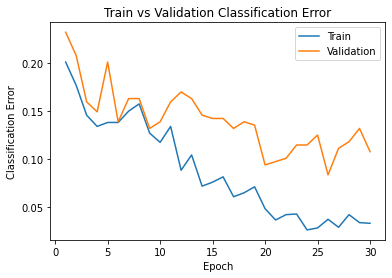

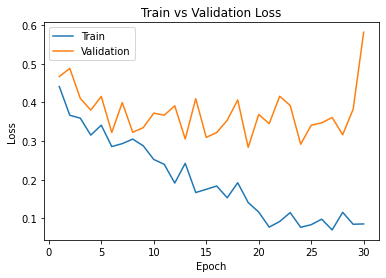

Finished training for the current setting: 
   Hyper-Parameters:  LR =  0.01  MU =  0.99  LRD =  0.6
Started New Setting: 
   Hyper-Parameters:  LR =  0.01  MU =  0.9  LRD =  0.4


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.01, 'mu': 0.9, 'lrd': 0.4}
Training with CUDA!
Epoch 1: Train err: 0.1986111111111111, Train loss: 0.4109458347161611 | Val err: 0.2361111111111111, Val loss: 0.4736238287554847 | Time: 45.67
Epoch 2: Train err: 0.09166666666666666, Train loss: 0.25452971789571976 | Val err: 0.1840277777777778, Val loss: 0.3764425218105316 | Time: 91.52
Epoch 3: Train err: 0.12361111111111112, Train loss: 0.27342606551117365 | Val err: 0.2013888888888889, Val loss: 0.48208890358606976 | Time: 137.15
Epoch 4: Train err: 0.07152777777777777, Train loss: 0.1716736961570051 | Val err: 0.1423611111111111, Val loss: 0.3363139049874412 | Time: 182.89
Epoch 5: Train err: 0.022222222222222223, Train loss: 0.07443952270680004 | Val err: 0.12152777777777778, Val loss: 0.2822032305929396 | Time: 228.43
Epoch 6: Train err: 0.013888888888888888, Train loss: 0.044367555166698165 | Val err: 0.10416666666666667, Val loss: 0.30622292641136384 | Time: 274.04
Epoch 7: Train err: 0.00625, Train loss: 0.02317757140

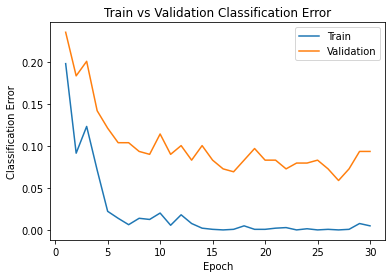

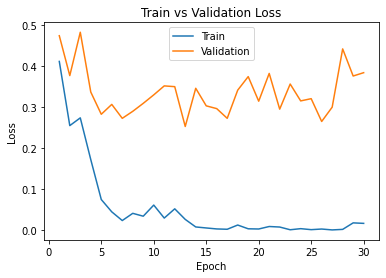

Finished training for the current setting: 
   Hyper-Parameters:  LR =  0.01  MU =  0.9  LRD =  0.4
Started New Setting: 
   Hyper-Parameters:  LR =  0.01  MU =  0.9  LRD =  0.5


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.01, 'mu': 0.9, 'lrd': 0.5}
Training with CUDA!
Epoch 1: Train err: 0.18472222222222223, Train loss: 0.39355798098776074 | Val err: 0.2222222222222222, Val loss: 0.4437985486454434 | Time: 45.78
Epoch 2: Train err: 0.08263888888888889, Train loss: 0.24351083801852333 | Val err: 0.1527777777777778, Val loss: 0.36106061273150974 | Time: 91.77
Epoch 3: Train err: 0.08541666666666667, Train loss: 0.21920331203275256 | Val err: 0.17708333333333334, Val loss: 0.3894587589634789 | Time: 137.62
Epoch 4: Train err: 0.08611111111111111, Train loss: 0.19473824120230146 | Val err: 0.1527777777777778, Val loss: 0.330308919151624 | Time: 183.25
Epoch 5: Train err: 0.016666666666666666, Train loss: 0.05948332517097394 | Val err: 0.125, Val loss: 0.27604127592510647 | Time: 228.95
Epoch 6: Train err: 0.022222222222222223, Train loss: 0.05994420002938972 | Val err: 0.09375, Val loss: 0.2798460384623872 | Time: 274.63
Epoch 7: Train err: 0.020833333333333332, Train loss: 0.05376492785289884 | Va

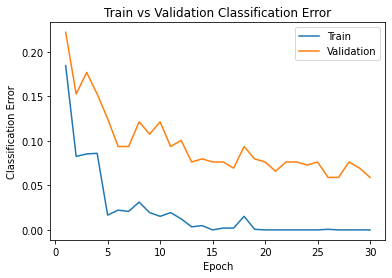

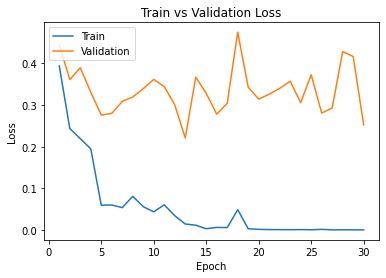

Finished training for the current setting: 
   Hyper-Parameters:  LR =  0.01  MU =  0.9  LRD =  0.5
Started New Setting: 
   Hyper-Parameters:  LR =  0.01  MU =  0.9  LRD =  0.6


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.01, 'mu': 0.9, 'lrd': 0.6}
Training with CUDA!
Epoch 1: Train err: 0.20347222222222222, Train loss: 0.41674226621786753 | Val err: 0.25, Val loss: 0.4493217004670037 | Time: 45.59
Epoch 2: Train err: 0.08611111111111111, Train loss: 0.2301533341407776 | Val err: 0.14930555555555555, Val loss: 0.3449784252378676 | Time: 91.39
Epoch 3: Train err: 0.09236111111111112, Train loss: 0.2349878105852339 | Val err: 0.16319444444444445, Val loss: 0.3643796543280284 | Time: 136.96
Epoch 4: Train err: 0.06527777777777778, Train loss: 0.15859627036584747 | Val err: 0.125, Val loss: 0.3889782362514072 | Time: 182.73
Epoch 5: Train err: 0.02361111111111111, Train loss: 0.07148165653149287 | Val err: 0.1111111111111111, Val loss: 0.2889549301730262 | Time: 228.66
Epoch 6: Train err: 0.02847222222222222, Train loss: 0.0834584171573321 | Val err: 0.09722222222222222, Val loss: 0.3675779054562251 | Time: 274.39
Epoch 7: Train err: 0.01597222222222222, Train loss: 0.048362576878733105 | Val err: 

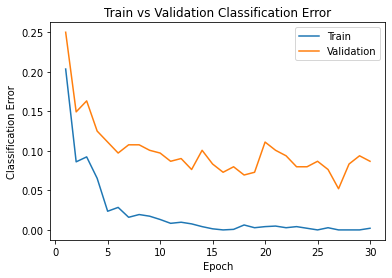

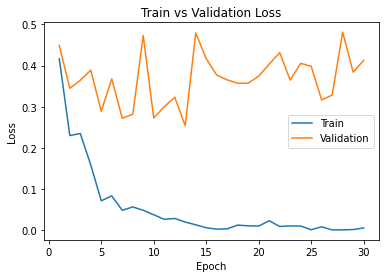

Finished training for the current setting: 
   Hyper-Parameters:  LR =  0.01  MU =  0.9  LRD =  0.6
Started New Setting: 
   Hyper-Parameters:  LR =  0.01  MU =  0.8  LRD =  0.4


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.01, 'mu': 0.8, 'lrd': 0.4}
Training with CUDA!
Epoch 1: Train err: 0.21388888888888888, Train loss: 0.4492185725106133 | Val err: 0.2152777777777778, Val loss: 0.46491464641359115 | Time: 45.95
Epoch 2: Train err: 0.10416666666666667, Train loss: 0.28647302356031207 | Val err: 0.1597222222222222, Val loss: 0.37168525324927437 | Time: 92.14
Epoch 3: Train err: 0.09513888888888888, Train loss: 0.2218779292371538 | Val err: 0.1840277777777778, Val loss: 0.36570871207449174 | Time: 137.95
Epoch 4: Train err: 0.04652777777777778, Train loss: 0.13266367523206604 | Val err: 0.13541666666666666, Val loss: 0.314451676275995 | Time: 183.78
Epoch 5: Train err: 0.014583333333333334, Train loss: 0.06325077356563674 | Val err: 0.125, Val loss: 0.2724706215990914 | Time: 229.81
Epoch 6: Train err: 0.008333333333333333, Train loss: 0.037037293964789976 | Val err: 0.09722222222222222, Val loss: 0.2502560309237904 | Time: 275.69
Epoch 7: Train err: 0.015277777777777777, Train loss: 0.0434423373

In [ ]:
lrs = [0.01, 0.001]
mus = [0.99, 0.9, 0.8]
lrds = [0.4, 0.5, 0.6]

for l in lrs:
  for m in mus:
    for d in lrds:
      print("=====================================================================")
      print("Started New Setting: ")
      print("   Hyper-Parameters: ", "LR = ", l, " MU = ", m, " LRD = ", d)

      # Train with default batch size and learning rate
      use_cuda = True

      model = TransferDenseNet121Classifier()
      _, kwargs = split_optim_dict(optim_dict['sgd_lrd'])
      lr, mu, lrd = l, m, d
      kwargs['lr'], kwargs['mu'], kwargs['lrd'] = lr, mu, lrd
      print(kwargs)
      optimizer = task_to_optimizer('sgd_lrd')(params=model.parameters(), **kwargs)
      optimizer = wrap_optimizer('sgd_lrd', optimizer)
      if use_cuda and torch.cuda.is_available():
        model.cuda()
        print("Training with CUDA!")
      else:
        print("CUDA not available...")
      other_param_names = 'lr{}_mu{}_lrd{}'.format(lr, mu, lrd)
      train(model, train_loader, val_loader, optimizer, other_param_names, batch_size=batch_size, num_epochs=30)


      #plot
      # Plotting is used for choosing hyperparameters
      model_path = get_model_name('densenet121Classifier_sgd_lrd', batch_size=batch_size, other_param_names = other_param_names, epoch=30)
      plot_training_curve(model_path, epochs=30)
      print("Finished training for the current setting: ")
      print("   Hyper-Parameters: ", "LR = ", l, " MU = ", m, " LRD = ", d)
      print("=====================================================================")

Batch Size: 64 Lr = 0.01, 0.001 Mu = 0.99, 0.9, 0.8

In [ ]:
batch_size = 64
train_loader, val_loader, test_loader, classes = get_data_loader(['Covid Negative', 'Covid Positive'], batch_size, 1)
# get number of images in training, validation, and testing sets
print('Num in training set:',len(train_loader)*batch_size)
print('Num in validation set:',len(val_loader)*batch_size)
print('Num in testing set:',len(test_loader)*batch_size)

Num in training set: 1408
Num in validation set: 256
Num in testing set: 256


Started New Setting: 
   Hyper-Parameters:  LR =  0.01  MU =  0.9  LRD =  0.4


Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

{'lr': 0.01, 'mu': 0.9, 'lrd': 0.4}
Training with CUDA!
Epoch 1: Train err: 0.24076704545454544, Train loss: 0.5311509330164302 | Val err: 0.26953125, Val loss: 0.5621500164270401 | Time: 213.20
Epoch 2: Train err: 0.1669034090909091, Train loss: 0.37399566309018567 | Val err: 0.17578125, Val loss: 0.4079447463154793 | Time: 252.41
Epoch 3: Train err: 0.10298295454545454, Train loss: 0.2506688284603032 | Val err: 0.1484375, Val loss: 0.3332139104604721 | Time: 287.37
Epoch 4: Train err: 0.03551136363636364, Train loss: 0.12055286866697398 | Val err: 0.14453125, Val loss: 0.31274472922086716 | Time: 322.27
Epoch 5: Train err: 0.01065340909090909, Train loss: 0.04840169161219488 | Val err: 0.10546875, Val loss: 0.23890568315982819 | Time: 357.23
Epoch 6: Train err: 0.005681818181818182, Train loss: 0.023423737549985 | Val err: 0.08203125, Val loss: 0.21590590104460716 | Time: 393.04
Epoch 7: Train err: 0.004971590909090909, Train loss: 0.02066499915566634 | Val err: 0.10546875, Val loss:

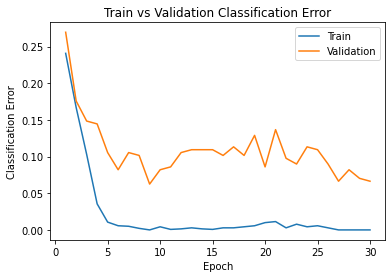

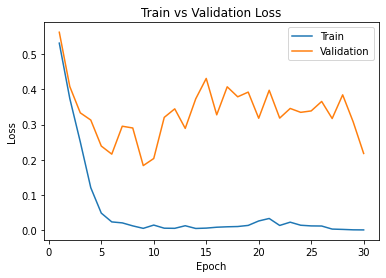

Finished training for the current setting: 
   Hyper-Parameters:  LR =  0.01  MU =  0.9  LRD =  0.4
Started New Setting: 
   Hyper-Parameters:  LR =  0.01  MU =  0.9  LRD =  0.5


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.01, 'mu': 0.9, 'lrd': 0.5}
Training with CUDA!
Epoch 1: Train err: 0.2528409090909091, Train loss: 0.5334018482403322 | Val err: 0.2734375, Val loss: 0.5513918846845627 | Time: 35.06
Epoch 2: Train err: 0.1328125, Train loss: 0.3252529515461488 | Val err: 0.16796875, Val loss: 0.37571846693754196 | Time: 70.42
Epoch 3: Train err: 0.09659090909090909, Train loss: 0.20701413330706683 | Val err: 0.15625, Val loss: 0.33492860198020935 | Time: 105.45
Epoch 4: Train err: 0.03480113636363636, Train loss: 0.1229539222337983 | Val err: 0.09375, Val loss: 0.24100562185049057 | Time: 140.48
Epoch 5: Train err: 0.017045454545454544, Train loss: 0.07228405951437625 | Val err: 0.09375, Val loss: 0.2095899134874344 | Time: 175.56
Epoch 6: Train err: 0.005681818181818182, Train loss: 0.03252665499563922 | Val err: 0.08984375, Val loss: 0.2226063683629036 | Time: 210.49
Epoch 7: Train err: 0.008522727272727272, Train loss: 0.03402400067584081 | Val err: 0.1171875, Val loss: 0.3434501811861992 

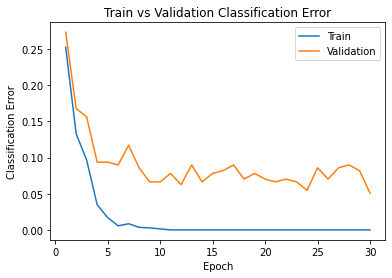

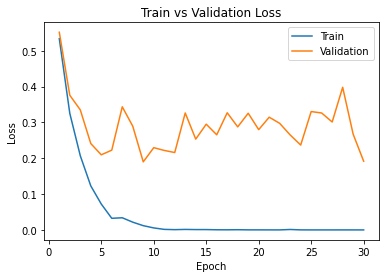

Finished training for the current setting: 
   Hyper-Parameters:  LR =  0.01  MU =  0.9  LRD =  0.5
Started New Setting: 
   Hyper-Parameters:  LR =  0.01  MU =  0.9  LRD =  0.6


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.01, 'mu': 0.9, 'lrd': 0.6}
Training with CUDA!
Epoch 1: Train err: 0.22017045454545456, Train loss: 0.49712413820353424 | Val err: 0.23828125, Val loss: 0.5331076681613922 | Time: 35.10
Epoch 2: Train err: 0.12428977272727272, Train loss: 0.30759036473252555 | Val err: 0.1484375, Val loss: 0.3639328181743622 | Time: 70.43
Epoch 3: Train err: 0.07670454545454546, Train loss: 0.17283217947591434 | Val err: 0.10546875, Val loss: 0.29992254823446274 | Time: 105.43
Epoch 4: Train err: 0.033380681818181816, Train loss: 0.105555459856987 | Val err: 0.12109375, Val loss: 0.32532257959246635 | Time: 140.39
Epoch 5: Train err: 0.008522727272727272, Train loss: 0.047122483057054604 | Val err: 0.0859375, Val loss: 0.24052774161100388 | Time: 175.43
Epoch 6: Train err: 0.004261363636363636, Train loss: 0.023332809944721786 | Val err: 0.08984375, Val loss: 0.23664359003305435 | Time: 210.42
Epoch 7: Train err: 0.004971590909090909, Train loss: 0.024750254349783063 | Val err: 0.10546875, Val

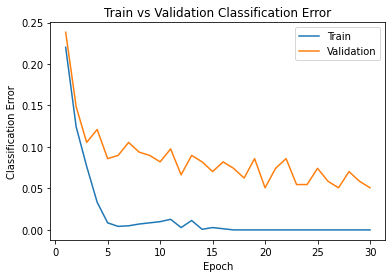

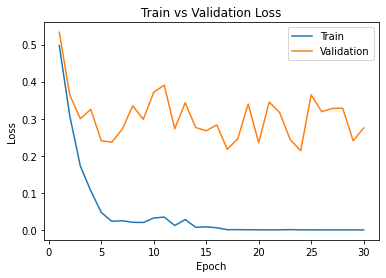

Finished training for the current setting: 
   Hyper-Parameters:  LR =  0.01  MU =  0.9  LRD =  0.6
Started New Setting: 
   Hyper-Parameters:  LR =  0.001  MU =  0.9  LRD =  0.4


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.001, 'mu': 0.9, 'lrd': 0.4}
Training with CUDA!
Epoch 1: Train err: 0.3806818181818182, Train loss: 0.6773010736162012 | Val err: 0.40234375, Val loss: 0.6826921999454498 | Time: 34.89
Epoch 2: Train err: 0.26917613636363635, Train loss: 0.6483321406624534 | Val err: 0.3203125, Val loss: 0.6563814133405685 | Time: 70.17
Epoch 3: Train err: 0.24431818181818182, Train loss: 0.6221420168876648 | Val err: 0.30859375, Val loss: 0.6362265050411224 | Time: 105.10
Epoch 4: Train err: 0.21519886363636365, Train loss: 0.5850916748697107 | Val err: 0.23046875, Val loss: 0.6066883653402328 | Time: 140.14
Epoch 5: Train err: 0.1981534090909091, Train loss: 0.5530998029492118 | Val err: 0.2265625, Val loss: 0.5762958973646164 | Time: 175.18
Epoch 6: Train err: 0.1875, Train loss: 0.5097666613080285 | Val err: 0.1796875, Val loss: 0.5296401679515839 | Time: 210.15
Epoch 7: Train err: 0.18323863636363635, Train loss: 0.47363857383077795 | Val err: 0.20703125, Val loss: 0.5139942839741707 | Ti

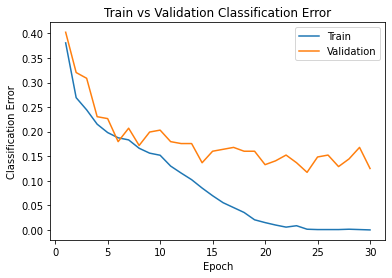

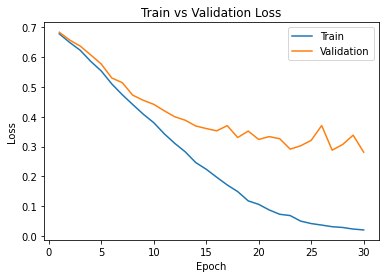

Finished training for the current setting: 
   Hyper-Parameters:  LR =  0.001  MU =  0.9  LRD =  0.4
Started New Setting: 
   Hyper-Parameters:  LR =  0.001  MU =  0.9  LRD =  0.5


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.001, 'mu': 0.9, 'lrd': 0.5}
Training with CUDA!
Epoch 1: Train err: 0.35795454545454547, Train loss: 0.6715676567771218 | Val err: 0.38671875, Val loss: 0.68010114133358 | Time: 35.01
Epoch 2: Train err: 0.2634943181818182, Train loss: 0.6368149681524797 | Val err: 0.3046875, Val loss: 0.6486898064613342 | Time: 70.34
Epoch 3: Train err: 0.2294034090909091, Train loss: 0.6007993465120142 | Val err: 0.26171875, Val loss: 0.6201515197753906 | Time: 105.18
Epoch 4: Train err: 0.19176136363636365, Train loss: 0.5526951497251337 | Val err: 0.20703125, Val loss: 0.582881435751915 | Time: 140.07
Epoch 5: Train err: 0.1903409090909091, Train loss: 0.5134617022492669 | Val err: 0.21875, Val loss: 0.5434097349643707 | Time: 175.02
Epoch 6: Train err: 0.17258522727272727, Train loss: 0.46208778565580194 | Val err: 0.1875, Val loss: 0.4934077113866806 | Time: 209.97
Epoch 7: Train err: 0.1669034090909091, Train loss: 0.42414876547726715 | Val err: 0.19921875, Val loss: 0.47817738354206085

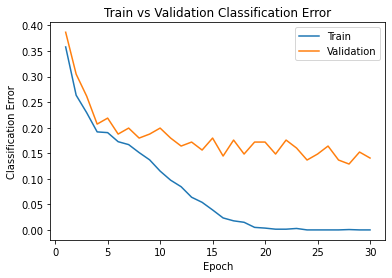

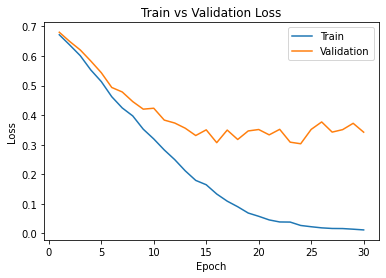

Finished training for the current setting: 
   Hyper-Parameters:  LR =  0.001  MU =  0.9  LRD =  0.5
Started New Setting: 
   Hyper-Parameters:  LR =  0.001  MU =  0.9  LRD =  0.6


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.001, 'mu': 0.9, 'lrd': 0.6}
Training with CUDA!
Epoch 1: Train err: 0.3430397727272727, Train loss: 0.6688822453672235 | Val err: 0.39453125, Val loss: 0.68048095703125 | Time: 34.77
Epoch 2: Train err: 0.2528409090909091, Train loss: 0.6265830749815161 | Val err: 0.25, Val loss: 0.6377831995487213 | Time: 69.79
Epoch 3: Train err: 0.22088068181818182, Train loss: 0.5811133059588346 | Val err: 0.2578125, Val loss: 0.5961496382951736 | Time: 104.58
Epoch 4: Train err: 0.2002840909090909, Train loss: 0.5236518518491224 | Val err: 0.20703125, Val loss: 0.5561311095952988 | Time: 139.25
Epoch 5: Train err: 0.18394886363636365, Train loss: 0.47814383560960944 | Val err: 0.2109375, Val loss: 0.5174220204353333 | Time: 173.90
Epoch 6: Train err: 0.16619318181818182, Train loss: 0.42056808959354053 | Val err: 0.16015625, Val loss: 0.45491529256105423 | Time: 208.62
Epoch 7: Train err: 0.14204545454545456, Train loss: 0.37819277291948145 | Val err: 0.16015625, Val loss: 0.4402587115764

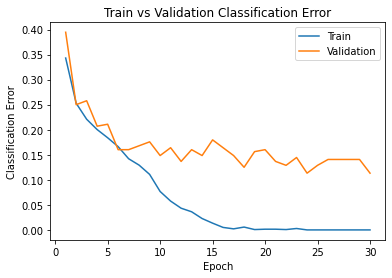

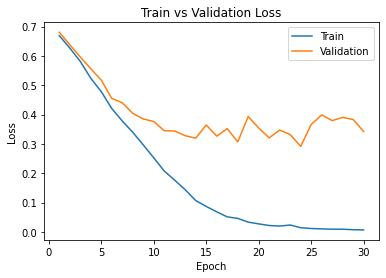

Finished training for the current setting: 
   Hyper-Parameters:  LR =  0.001  MU =  0.9  LRD =  0.6


In [ ]:
lrs = [0.01, 0.001]
mus = [0.9]
lrds = [0.4, 0.5, 0.6]

for l in lrs:
  for m in mus:
    for d in lrds:
      print("=====================================================================")
      print("Started New Setting: ")
      print("   Hyper-Parameters: ", "LR = ", l, " MU = ", m, " LRD = ", d)

      # Train with default batch size and learning rate
      use_cuda = True

      model = TransferDenseNet121Classifier()
      _, kwargs = split_optim_dict(optim_dict['sgd_lrd'])
      lr, mu, lrd = l, m, d
      kwargs['lr'], kwargs['mu'], kwargs['lrd'] = lr, mu, lrd
      print(kwargs)
      optimizer = task_to_optimizer('sgd_lrd')(params=model.parameters(), **kwargs)
      optimizer = wrap_optimizer('sgd_lrd', optimizer)
      if use_cuda and torch.cuda.is_available():
        model.cuda()
        print("Training with CUDA!")
      else:
        print("CUDA not available...")
      other_param_names = 'lr{}_mu{}_lrd{}'.format(lr, mu, lrd)
      train(model, train_loader, val_loader, optimizer, other_param_names, batch_size=batch_size, num_epochs=30)


      #plot
      # Plotting is used for choosing hyperparameters
      model_path = get_model_name('densenet121Classifier_sgd_lrd', batch_size=batch_size, other_param_names = other_param_names, epoch=30)
      plot_training_curve(model_path, epochs=30)
      print("Finished training for the current setting: ")
      print("   Hyper-Parameters: ", "LR = ", l, " MU = ", m, " LRD = ", d)
      print("=====================================================================")

## Test with Testing Set

In [ ]:
def evaluate_loss_err_fp_fn(net, loader, criterion):
    #predicted 1, actually truth is 0
    total_false_positive = 0.0
    #predicted 0, actually truth is 1
    total_false_negative = 0.0
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if use_cuda and torch.cuda.is_available():
          inputs = inputs.cuda()
          labels = labels.cuda()
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)

        #predicted posotive and it is a wrong prediction
        false_pos = (((outputs > 0.0).squeeze().long() != labels) & ((outputs > 0.0).squeeze().long() == 1))
        #predicted negitive and it is a wrong prediction
        false_neg = (((outputs > 0.0).squeeze().long() != labels) & ((outputs > 0.0).squeeze().long() == 0))
        #loss
        loss_val = criterion(outputs+1e-10, labels.float())
        #total_error
        incorrect_pred = (outputs > 0.0).squeeze().long() != labels

        total_false_positive += int(false_pos.sum())
        total_false_negative += int(false_neg.sum())
        total_err += int(incorrect_pred.sum())
        total_loss += loss_val.item()
        total_epoch += len(labels.tolist())

    false_posotive = float(total_false_positive) / total_epoch
    false_negative = float(total_false_negative) / total_epoch
    error = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return false_posotive, false_negative, error, loss

In [ ]:
def get_false_posotive(net, loader):
    #predicted 1, actually truth is 0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        # print("hiiiiii")
        # print('inputs: ', inputs)
        # print('labels: ', labels)
        if use_cuda and torch.cuda.is_available():
          inputs = inputs.cuda()
          labels = labels.cuda()
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        #predicted posotive and it is a wrong prediction
        incorrect_pred = (((outputs > 0.0).squeeze().long() != labels) & ((outputs > 0.0).squeeze().long() == 1))
        # print(incorrect_pred)
        total_err += int(incorrect_pred.sum())
        total_epoch += len(labels.tolist())

    false_posotive = float(total_err) / total_epoch
    return false_posotive

In [ ]:
def get_false_negative(net, loader):
    #predicted 0, actually truth is 1
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        # print("hiiiiii")
        # print('inputs: ', inputs)
        # print('labels: ', labels)
        if use_cuda and torch.cuda.is_available():
          inputs = inputs.cuda()
          labels = labels.cuda()
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        #predicted negative and it is a wrong prediction
        incorrect_pred = (((outputs > 0.0).squeeze().long() != labels) & ((outputs > 0.0).squeeze().long() == 0))
        # print(incorrect_pred)
        total_err += int(incorrect_pred.sum())
        total_epoch += len(labels.tolist())

    false_negative = float(total_err) / total_epoch
    return false_negative

In [ ]:
#Settings
bs = 64
lr=0.01
mu=0.9
lrd = 0.6
convergence_epoch = 21
print("Best Model's Setting: ")
print('    batch size = {}, learning rate = {}'.format(bs, lr))

#Load Data
train_loader, val_loader, test_loader, classes = get_data_loader(['Covid Negative', 'Covid Positive'], bs, 1)
print("Finished loading data...")

#Load Model
use_cuda = True
model = TransferDenseNet121Classifier()
_, kwargs = split_optim_dict(optim_dict['sgd_lrd'])
lr, mu, lrd = lr, mu, lrd
kwargs['lr'], kwargs['mu'], kwargs['lrd'] = lr, mu, lrd
print("Best Model's Optimizer's Setting: ")
print("    ", kwargs)
optimizer = task_to_optimizer('sgd_lrd')(params=model.parameters(), **kwargs)
optimizer = wrap_optimizer('sgd_lrd', optimizer)
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print("Training with CUDA!")
else:
  print("CUDA not available...")
other_param_names = 'lr{}_mu{}_lrd{}'.format(lr, mu, lrd)
model_path = get_model_name('densenet121Classifier_sgd_lrd', bs, other_param_names, epoch=convergence_epoch-1)
# no cuda version: 
# model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
state = torch.load(model_path)
model.load_state_dict(state)
print("Finished loading model...")

#get error, false positive, false negative on test set 
print("Starting to evaluate model's performance...")
test_false_posotive, test_false_negative, test_err, test_loss = evaluate_loss_err_fp_fn(model, test_loader, nn.BCEWithLogitsLoss())
print("    Test classification error of the best model is:", test_err)
print("    Test false positive rate of the best model is:", test_false_posotive)
print("    Test false negative rate of the best model is:", test_false_negative)

Best Model's Setting: 
    batch size = 64, learning rate = 0.01
Finished loading data...


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Best Model's Optimizer's Setting: 
     {'lr': 0.01, 'mu': 0.9, 'lrd': 0.6}
Training with CUDA!
Finished loading model...
Starting to evaluate model's performance...
    Test classification error of the best model is: 0.0859375
    Test false positive rate of the best model is: 0.0703125
    Test false negative rate of the best model is: 0.015625


Useful Links:  
https://www.kaggle.com/code/jaeboklee/pytorch-transfer-learning-with-densenet/notebook  
https://www.upgrad.com/blog/basic-cnn-architecture/  
https://towardsdatascience.com/a-bunch-of-tips-and-tricks-for-training-deep-neural-networks-3ca24c31ddc8  
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8189817/  
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8300985/